# Librerie

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf
import warnings

# Importazione dataset e preprocessing

In [20]:
# Carico dati
restaurants = pd.read_csv('https://raw.githubusercontent.com/CoroTheBoss/DSL-project/main/restaurants.csv', sep=";")
restaurants['data'] = pd.to_datetime(restaurants['data'], format='%Y%m%d')
towns = pd.read_excel('Restaurant-Town.xlsx', header = None)
towns.columns = ['ristorante', 'città']
start_date = pd.Timestamp(2020, 5, 7)
restaurants = restaurants[restaurants['data'] >= start_date]
rest_towns = pd.merge(restaurants, towns, on='ristorante', how='inner')
rest_towns['day'] = rest_towns['data'].dt.strftime('%A')

def get_holiday(date):
    year = date.year
    it_holidays = holidays.Italy(years=year)
    return it_holidays.get(date)

rest_towns['festività'] = rest_towns['data'].apply(get_holiday)
df = rest_towns[rest_towns['ristorante']=='R002']
df = df.iloc[:-50]
df

,data,scontrini,lordototale,ristorante,città,day,festività
5600,2020-05-07,202.0,14060.5437,R002,Piacenza,Thursday,None
5601,2020-05-08,254.0,18705.5960,R002,Piacenza,Friday,None
5602,2020-05-09,246.0,20172.3242,R002,Piacenza,Saturday,None
5603,2020-05-10,214.0,17053.5960,R002,Piacenza,Sunday,None
5604,2020-05-11,212.0,14738.3180,R002,Piacenza,Monday,None
...,...,...,...,...,...,...,...
6665,2023-04-07,1073.0,61274.3320,R002,Piacenza,Friday,None
6666,2023-04-08,1030.0,59125.7408,R002,Piacenza,Saturday,None
6667,2023-04-09,579.0,33832.5057,R002,Piacenza,Sunday,Pasqua di Resurrezione
6668,2023-04-10,861.0,56245.1484,R002,Piacenza,Monday,Lunedì dell'Angelo


# Plot serie temporale

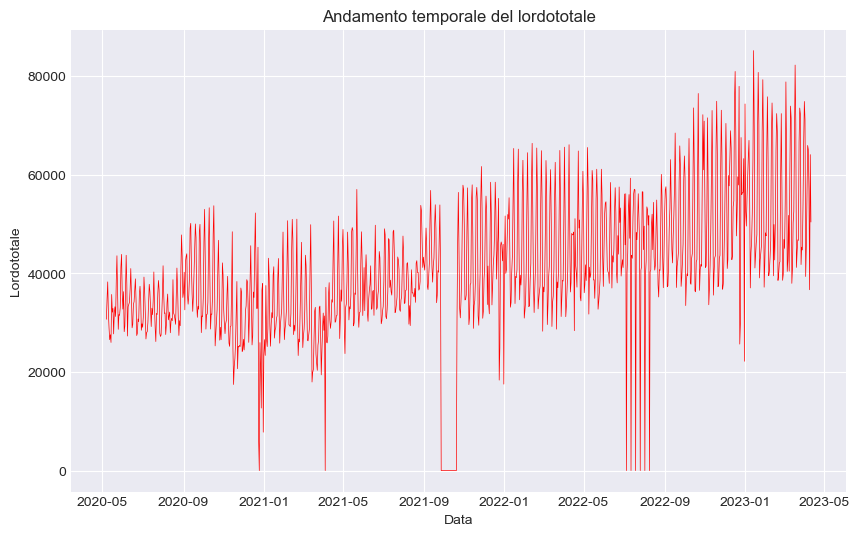

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df['data'],df['lordototale'],
         color='red', linewidth=0.5)
plt.title('Andamento temporale del lordototale')
plt.xlabel('Data')
plt.ylabel('Lordototale')
plt.grid(True)
# Salva il grafico ad alta qualità
#plt.savefig('Rist1_nocov.png', dpi=300, bbox_inches='tight')
plt.show()

# Definizione, addestramento RNN

In [14]:
# Preparazione dei dati
data = df['lordototale'].values
data = data.reshape(-1, 1) 

# Divisione tra dati di addestramento e test
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Normalizzazione dei dati
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Creazione delle finestre di dati
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        label = data[i + window_size]
        sequences.append((seq, label))
    return sequences

window_size = 10
train_sequences = create_sequences(train_data, window_size)
test_sequences = create_sequences(test_data, window_size)

X_train = np.array([seq for seq, label in train_sequences])
y_train = np.array([label for seq, label in train_sequences])
X_test = np.array([seq for seq, label in test_sequences])
y_test = np.array([label for seq, label in test_sequences])

# Creazione del modello RNN
model = Sequential([
    SimpleRNN(32, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

# Compilazione del modello con MSE
model.compile(optimizer='adam', loss='mean_squared_error')

# Definizione dell'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello con early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
53/53 [==============================] - 1s 3ms/step - loss: 0.7842 - val_loss: 1.1863
Epoch 2/100
53/53 [==============================] - 0s 2ms/step - loss: 0.5186 - val_loss: 0.9815
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3455 - val_loss: 0.7384
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2964 - val_loss: 0.7439
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2787 - val_loss: 0.6419
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2552 - val_loss: 0.7549
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2459 - val_loss: 0.7207
Epoch 8/100
53/53 [==============================] - 0s 1ms/step - loss: 0.2353 - val_loss: 0.7216
Epoch 9/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2321 - val_loss: 0.6222
Epoch 10/100
53/53 [==============================] - 0s 1ms/step - loss: 0.2251 - val_loss: 0.6256
Epoch 11/

# Grafico MSE

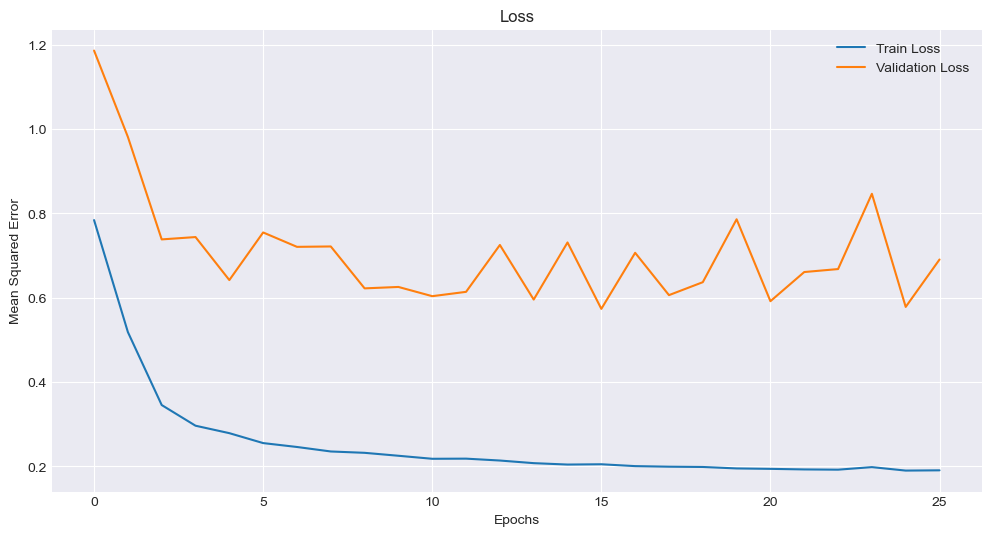

In [15]:
# Plot della curva di perdita (MSE)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
# Salva il grafico ad alta qualità
#plt.savefig('loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcolo metriche

In [17]:
# Ignora tutti i messaggi di avviso (warning)
warnings.filterwarnings("ignore")

predictions = model.predict(X_test)
predictions_denorm = scaler.inverse_transform(predictions)
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcola l'errore assoluto percentuale medio (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcola l'errore assoluto medio (MAE)
mae = mean_absolute_error(y_test_denorm, predictions_denorm)

# Calcola l'errore quadratico medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))

# Calcola l'errore percentuale medio (MPE)
mpe = np.mean((y_test_denorm - predictions_denorm) / y_test_denorm) * 100

# Calcola l'errore percentuale assoluto medio (MAPE)
mape = calculate_mape(y_test_denorm, predictions_denorm)

# Calcola l'autocorrelazione di previsioni
acf1 = acf(y_test_denorm - predictions_denorm, nlags=1)[1]

# Creazione di un DataFrame per mostrare tutte le metriche in maniera ordinata
metrics_df = pd.DataFrame({
    'RMSE': [rmse],
    'MAE': [mae],
    'MPE': [mpe],
    'MAPE': [mape],
    'ACF1': [acf1]
})

print(metrics_df)

7/7 [==============================] - 0s 831us/step
          RMSE          MAE       MPE       MAPE      ACF1
0  9215.689128  6226.337312  3.873449  11.833704 -0.166193


# Test normalitá redisdui

Media dei Residui: -3125.7644257659313
Varianza dei Residui: 75158522.86429495


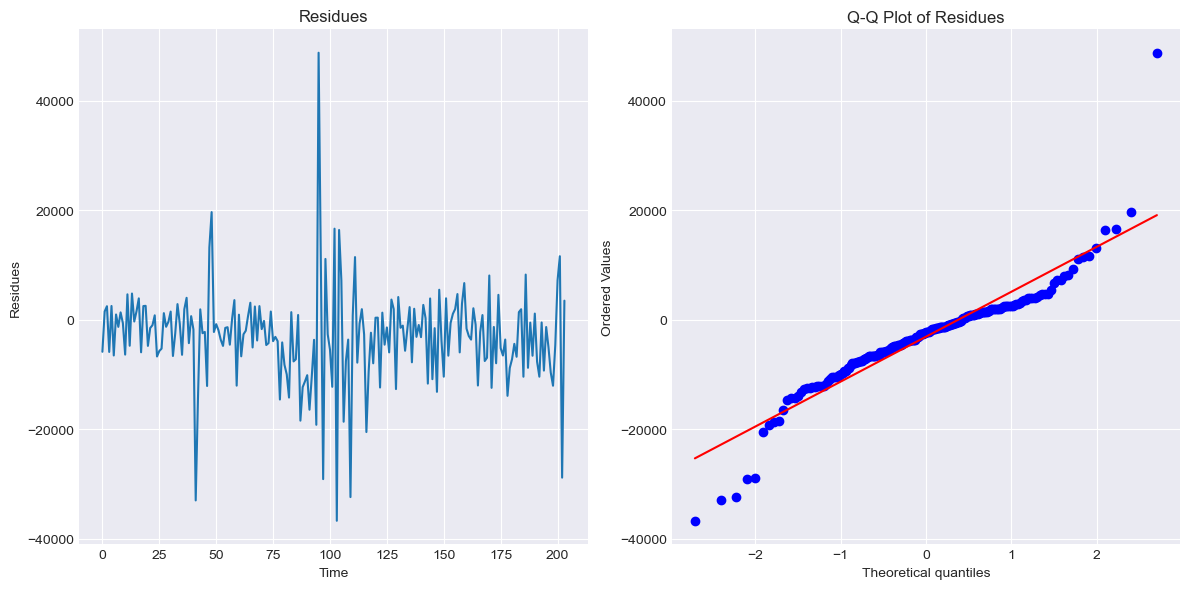

In [18]:
# Calcolo gli errori residui
residues = (predictions_denorm - y_test_denorm).flatten()

# Calcolo la media e la varianza dei residui
residues_mean = np.mean(residues)
residues_var = np.var(residues)

print("Media dei Residui:", residues_mean)
print("Varianza dei Residui:", residues_var)

# Creo una griglia di subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Grafico dei residui
plt.subplot(1, 2, 1)
plt.plot(residues)
plt.title('Residues')
plt.xlabel('Time')
plt.ylabel('Residues')

# Subplot 2: Grafico Q-Q
plt.subplot(1, 2, 2)
stats.probplot(residues, plot=plt)
plt.title('Q-Q Plot of Residues')

plt.tight_layout()
plt.show()

# Plot previsioni

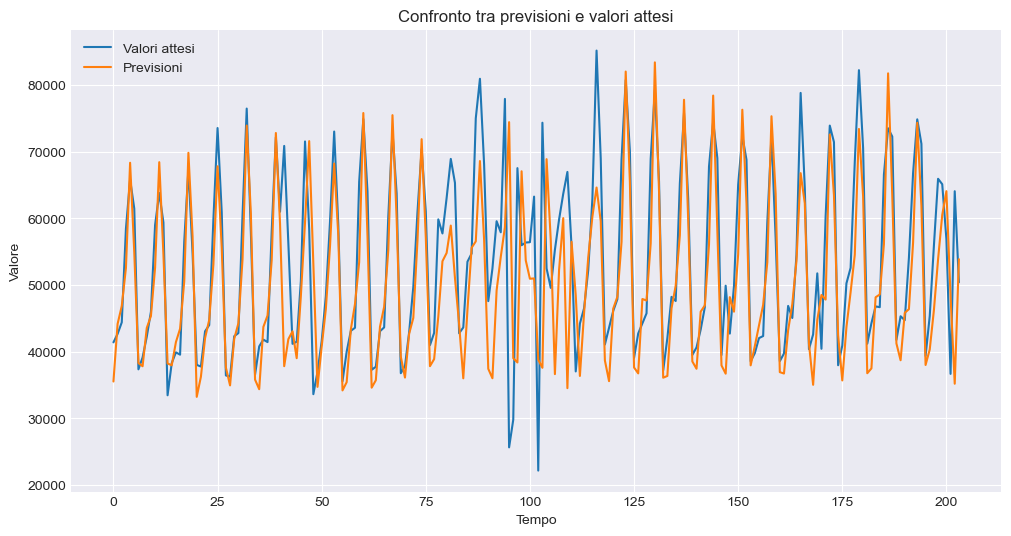

In [19]:
# Plot previsioni contro valori attesi
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label='Valori attesi')
plt.plot(predictions_denorm, label='Previsioni')
plt.xlabel('Tempo')
plt.ylabel('Valore')
plt.title('Confronto tra previsioni e valori attesi')
plt.legend()
# Salva il grafico ad alta qualità
#plt.savefig('RNN_previsioni.png', dpi=300, bbox_inches='tight')
plt.show()

# PREVISIONI FUTURE 6 RISTORANTI

In [9]:
# Lista dei ristoranti da R000 a R005
ristoranti_da_addestrare = ['R000', 'R001', 'R002', 'R003', 'R004', 'R005']

# Creazione di un dizionario per memorizzare i modelli addestrati
modelli_addestrati = {}

# Itero sui ristoranti da addestrare
for ristorante in ristoranti_da_addestrare:
    # Filtro i dati per il ristorante corrente
    df_ristorante = rest_towns[rest_towns['ristorante'] == ristorante]
    df_ristorante = df_ristorante.iloc[:-50]
    
    # Preparazione dei dati
    data_ristorante = df_ristorante['lordototale'].values
    data_ristorante = data_ristorante.reshape(-1, 1)
    
    # Divisione tra dati di addestramento e test
    train_size_ristorante = int(0.8 * len(data_ristorante))
    train_data_ristorante = data_ristorante[:train_size_ristorante]
    test_data_ristorante = data_ristorante[train_size_ristorante:]
    
    # Normalizzazione dei dati
    scaler_ristorante = StandardScaler()
    train_data_ristorante = scaler_ristorante.fit_transform(train_data_ristorante)
    test_data_ristorante = scaler_ristorante.transform(test_data_ristorante)
    
    # Creazione delle finestre di dati
    train_sequences_ristorante = create_sequences(train_data_ristorante, window_size)
    test_sequences_ristorante = create_sequences(test_data_ristorante, window_size)
    
    X_train_ristorante = np.array([seq for seq, label in train_sequences_ristorante])
    y_train_ristorante = np.array([label for seq, label in train_sequences_ristorante])
    X_test_ristorante = np.array([seq for seq, label in test_sequences_ristorante])
    y_test_ristorante = np.array([label for seq, label in test_sequences_ristorante])
    
    # Creazione del modello RNN
    model_ristorante = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(window_size, 1)),
        Dense(1)
    ])
    
    # Compilazione del modello con MSE
    model_ristorante.compile(optimizer='adam', loss='mean_squared_error')
    
    # Definizione dell'early stopping
    early_stopping_ristorante = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Addestramento del modello con early stopping
    history_ristorante = model_ristorante.fit(X_train_ristorante, y_train_ristorante, epochs=100, batch_size=16, validation_data=(X_test_ristorante, y_test_ristorante), callbacks=[early_stopping_ristorante])
    
    # Memorizzazione il modello addestrato nel dizionario
    modelli_addestrati[ristorante] = (model_ristorante, scaler_ristorante)

Epoch 1/100
53/53 [==============================] - 1s 3ms/step - loss: 0.6272 - val_loss: 2.1636
Epoch 2/100
53/53 [==============================] - 0s 2ms/step - loss: 0.5043 - val_loss: 1.8247
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.4369 - val_loss: 1.4269
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3662 - val_loss: 0.9281
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3211 - val_loss: 0.7058
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3121 - val_loss: 0.6851
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2929 - val_loss: 0.6920
Epoch 8/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2856 - val_loss: 0.7868
Epoch 9/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2757 - val_loss: 0.6493
Epoch 10/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2769 - val_loss: 0.6266
Epoch 11/

53/53 [==============================] - 0s 2ms/step - loss: 0.2272 - val_loss: 0.5640
Epoch 28/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2211 - val_loss: 0.5750
Epoch 29/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2193 - val_loss: 0.5536
Epoch 30/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2144 - val_loss: 0.5525
Epoch 31/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2184 - val_loss: 0.6837
Epoch 32/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2116 - val_loss: 0.5471
Epoch 33/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2080 - val_loss: 0.5532
Epoch 34/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2108 - val_loss: 0.5422
Epoch 35/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2060 - val_loss: 0.5421
Epoch 36/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2051 - val_loss: 0.6134
Epoch 37/100


1/1 [==============================] - 0s 14ms/step


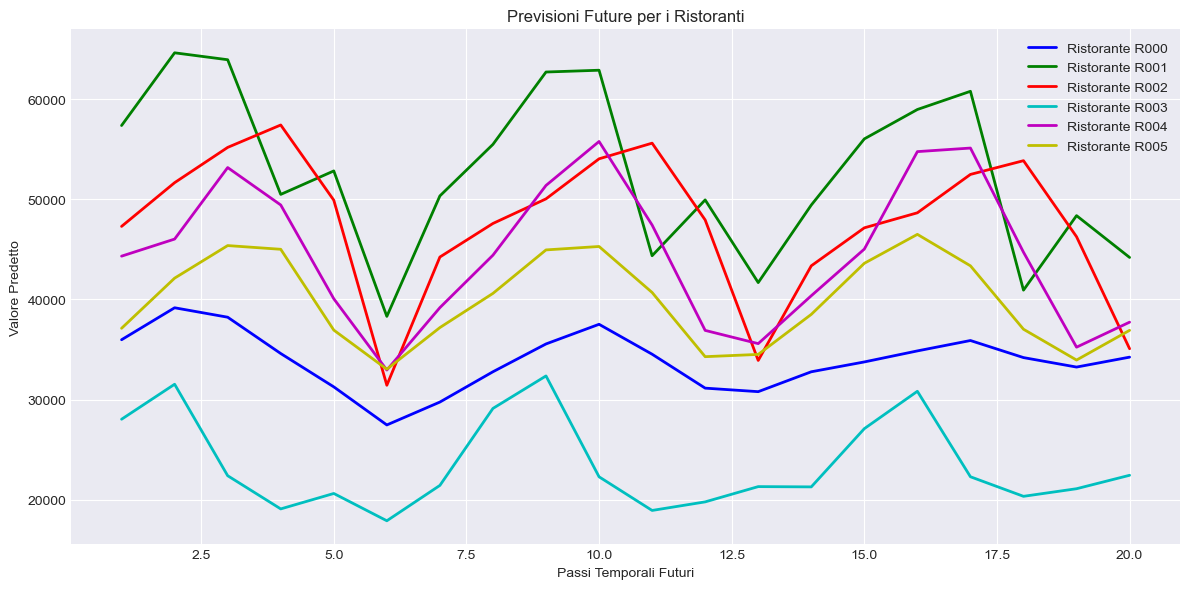

In [10]:
def generate_future_predictions(model, scaler, initial_sequence, future_steps):
    predictions = []

    # Copio la sequenza iniziale
    current_sequence = initial_sequence.copy()

    for _ in range(future_steps):
        # Effettuo una previsione per il passo successivo
        next_step = model.predict(current_sequence.reshape(1, -1, 1))
        
        # Aggiungo la previsione alla lista delle previsioni
        predictions.append(next_step[0, 0])
        
        # Aggiorno la sequenza corrente con la nuova previsione
        current_sequence = np.roll(current_sequence, shift=-1)
        current_sequence[-1] = next_step[0, 0]
        
    # Reverto la normalizzazione alle previsioni
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    return predictions

# Numero di previsioni future da generare
future_steps = 20

# Creo una figura per il plot
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-darkgrid')

# Colori per le linee dei ristoranti
colors = ['b', 'g', 'r', 'c', 'm', 'y']

for i, ristorante in enumerate(ristoranti_da_addestrare):
    # Ottengo il modello e lo scaler dal dizionario
    model_ristorante, scaler_ristorante = modelli_addestrati[ristorante]
    
    # Prendo l'ultima sequenza di dati dal set di test
    last_sequence = X_test_ristorante[-1]
    
    # Genero le previsioni future per il ristorante corrente
    future_predictions = generate_future_predictions(model_ristorante, scaler_ristorante, last_sequence, future_steps)
    
    # Creo un array di passi temporali per il plot
    time_steps = np.arange(1, future_steps + 1)
    
    # Plotto le previsioni future con stile
    plt.plot(time_steps, future_predictions, label=f'Ristorante {ristorante}', color=colors[i], linewidth=2)

# Aggiungo etichette e legenda al plot
plt.xlabel('Passi Temporali Futuri')
plt.ylabel('Valore Predetto')
plt.title('Previsioni Future per i Ristoranti')
plt.legend()

# Mostro il plot
plt.tight_layout()
# Salvo il grafico ad alta qualità
#plt.savefig('future.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Crezione un dizionario per memorizzare le somme delle previsioni per ciascun ristorante
total_revenues_by_restaurant = {}

for ristorante in ristoranti_da_addestrare:
    # Ottengo il modello e lo scaler dal dizionario
    model_ristorante, scaler_ristorante = modelli_addestrati[ristorante]
    
    # Prendo l'ultima sequenza di dati dal set di test
    last_sequence = X_test_ristorante[-1]
    
    # Genero le previsioni future per il ristorante corrente
    future_predictions = generate_future_predictions(model_ristorante, scaler_ristorante, last_sequence, future_steps)
    
    # Calcolo la somma delle previsioni per il ristorante corrente
    total_revenue = np.sum(future_predictions)
    
    # Memorizzo la somma delle previsioni nel dizionario
    total_revenues_by_restaurant[ristorante] = total_revenue

# Stampo le stime dell'incasso totale per ciascun ristorante
for ristorante, revenue in total_revenues_by_restaurant.items():
    print(f"Stima dell'incasso totale per Ristorante {ristorante} nei prossimi 30 giorni: {revenue:.2f} Euro")

1/1 [==============================] - 0s 12ms/step
Stima dell'incasso totale per Ristorante R000 nei prossimi 30 giorni: 677847.94 Euro
Stima dell'incasso totale per Ristorante R001 nei prossimi 30 giorni: 1053813.12 Euro
Stima dell'incasso totale per Ristorante R002 nei prossimi 30 giorni: 953230.25 Euro
Stima dell'incasso totale per Ristorante R003 nei prossimi 30 giorni: 470251.28 Euro
Stima dell'incasso totale per Ristorante R004 nei prossimi 30 giorni: 889735.88 Euro
Stima dell'incasso totale per Ristorante R005 nei prossimi 30 giorni: 797097.44 Euro
